In [1]:
import argparse
import csv
import logging

from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torchvision import transforms

from train.seg_evaluate import evaluate
from models.seg.UNet.unet_model import UNet, R2UNet
from utils.data_loading import SegmentDatasetJson, SegmentationDatasetDirectory
from models.seg.MaskRCNN.model import MaskRCNNResNet50
from utils.indicators import segmentation_indicators
from utils.utils import EarlyStopping, ToHSV, ApplyCLAHE, mpl, show_transformed_images

In [2]:
image_dir = 'E:/Datas/work/HairEffect/RawData/HAM10000/HAM_Train/Image'
mask_dir = 'E:/Datas/work/HairEffect/RawData/HAM10000/HAM_Train/Mask'

val = 0.2
size = (256, 256)
num_classes = 2
epochs = 200
batch_size = 8
lr = 1e-4
amp = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

In [3]:
model = UNet(n_channels=3, n_classes=num_classes, bilinear=False)
model = model.to(device=device, memory_format=torch.channels_last)

In [4]:
# set save directory
now_time = datetime.now().strftime("%Y-%m-%d") 
now_h = datetime.now().strftime("%H")

dir_checkpoint = Path(f'../train_save/checkpoints/HAM/UNet')
dir_indicators = Path(f'../train_save/indicators/HAM/UNet')
Path(f'{dir_checkpoint}/{now_time}/{now_h}').mkdir(parents=True, exist_ok=True)
Path(f'{dir_indicators}/{now_time}/{now_h}').mkdir(parents=True, exist_ok=True)
dir_checkpoint_save = Path(f'{dir_checkpoint}/{now_time}/{now_h}')
dir_indicators_save = Path(f'{dir_indicators}/{now_time}/{now_h}')

# save indicators in csv
indicators_header = ['epoch', 'train_loss', 'train_dice', 'train_iou', 'train_f1', 'train_recall',
                     'train_precision',
                     'val_dice', 'val_iou', 'val_f1', 'val_recall', 'val_precision', 'learning_rate']
epoch_csv_path = f"{dir_indicators_save}/train_indicators.csv"

with open(epoch_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(indicators_header)

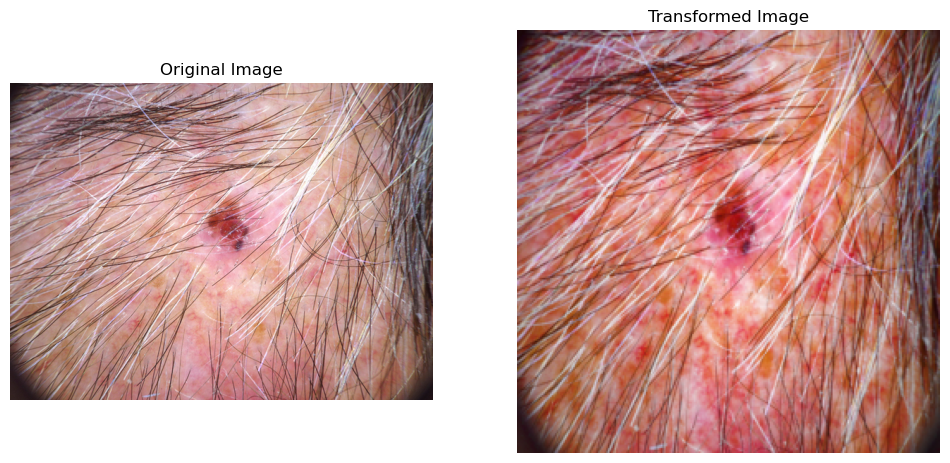

In [5]:
transform = transforms.Compose([
    transforms.Resize(size),
    ApplyCLAHE(channel='HSV', enhance=1),
    transforms.ToTensor(),
])

target_image = 'ISIC_0026343.jpg'
show_transformed_images(f'{image_dir}/{target_image}', transform)

In [6]:
# Create dataset
dataset = SegmentationDatasetDirectory(image_dir, mask_dir, size, [0, 255], transform=transform)
n_val = int(len(dataset) * val)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

# Create data loaders os.cpu_count()
loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Images size:  {size}
        Mixed Precision: {amp}
    ''')

INFO:root:Create dataset with 8015
INFO:root:Starting training:
        Epochs:          200
        Batch size:      8
        Learning rate:   0.0001
        Training size:   6412
        Validation size: 1603
        Device:          cuda
        Images size:  (256, 256)
        Mixed Precision: True
    


In [7]:
# Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=10)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
early_stopping = EarlyStopping(patience=5, verbose=True)
criterion = nn.CrossEntropyLoss()
global_step = 0
best_dice = 0

In [8]:
# Begin training
for epoch in range(1, epochs + 1):
    model.train()
    
    # save epoch train indicators
    epoch_train_loss = np.array([])
    epoch_train_dice = np.array([])
    epoch_train_iou = np.array([])
    epoch_train_f1 = np.array([])
    epoch_train_recall = np.array([])
    epoch_train_precision = np.array([])
    # save epoch val
    epoch_val_dice = np.array([])
    epoch_val_iou = np.array([])
    epoch_val_f1 = np.array([])
    epoch_val_recall = np.array([])
    epoch_val_precision = np.array([])
    
    # Record the number of verifications performed in each epoch
    val_times_every_epoch = 0
    
    with (tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar):
        for batch in train_loader:
            images, masks = batch['images'], batch['masks']
            
            assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images_0 have {images.shape[1]} channels. Please check that ' \
                    'the images_0 are loaded correctly.'
            
            images_torch = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            masks_torch = masks.to(device=device, dtype=torch.long)
            
            with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                masks_pred = model(images_torch)
                
                loss = criterion(masks_pred, masks_torch)
                train_indicators_dict = segmentation_indicators(F.softmax(masks_pred, dim=1).float(),
                                                                        F.one_hot(masks_torch, num_classes).
                                                                        permute(0, 3, 1, 2).float(), multi_class=True, places=3)
            d_loss = 1 - train_indicators_dict['dice']
            loss += d_loss
            
            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            grad_scaler.step(optimizer)
            grad_scaler.update()
            pbar.update(images.shape[0])
            
            # update epoch information
            epoch_train_loss = np.append(epoch_train_loss, loss.cpu().detach().numpy())
            epoch_train_dice = np.append(epoch_train_dice, train_indicators_dict['dice'])
            epoch_train_iou = np.append(epoch_train_iou, train_indicators_dict['iou'])
            epoch_train_f1 = np.append(epoch_train_f1, train_indicators_dict['f1'])
            epoch_train_recall = np.append(epoch_train_recall, train_indicators_dict['recall'])
            epoch_train_precision = np.append(epoch_train_precision, train_indicators_dict['precision'])
            pbar.set_postfix(**{'loss (batch)': loss.item()})
            global_step += 1
            
            # Evaluation round every 5 batch size do a evaluation
            division_step = (n_train // (5 * batch_size))
            if division_step > 0:
                if global_step % division_step == 0:
                    val_times_every_epoch += 1
                    val_score = evaluate(model, val_loader, device, amp)
                    # score every batch
                    val_dice, val_iou, val_f1 = val_score[0], val_score[1], val_score[2]
                    val_recall, val_precision = val_score[3], val_score[4]
                    
                    # average score for every valuate
                    val_dice_avg = sum(val_dice) / max(len(val_loader), 1)
                    val_iou_avg = sum(val_iou) / max(len(val_loader), 1)
                    val_f1_avg = sum(val_f1) / max(len(val_loader), 1)
                    val_recall_avg = sum(val_recall) / max(len(val_loader), 1)
                    val_precision_avg = sum(val_precision) / max(len(val_loader), 1)
                    
                    # score for every batch in every epoch
                    epoch_val_dice = np.append(epoch_val_dice, val_dice_avg)
                    epoch_val_iou = np.append(epoch_val_iou, val_iou_avg)
                    epoch_val_f1 = np.append(epoch_val_f1, val_f1_avg)
                    epoch_val_recall = np.append(epoch_val_recall, val_recall_avg)
                    epoch_val_precision = np.append(epoch_val_precision, val_precision_avg)
                    
                    logging.info('Validation Dice score: {}'.format(np.round(val_dice_avg, 3)))
                    logging.info('Validation Iou score: {}'.format(np.round(val_iou_avg, 3)))
                    logging.info('Validation f1 score: {}'.format(np.round(val_f1_avg, 3)))
                    logging.info('Validation Recall score: {}'.format(np.round(val_recall_avg, 3)))
                    logging.info('Validation Precision score: {}'.format(np.round(val_precision_avg, 3)))
                    
                    scheduler.step(val_dice_avg)
                    
    stage = len(train_loader)
    train_loss_avg = np.round((sum(epoch_train_loss) / stage), 3)
    train_dice_avg = np.round((sum(epoch_train_dice) / stage), 3)
    train_iou_avg = np.round((sum(epoch_train_iou) / stage), 3)
    train_f1_avg = np.round((sum(epoch_train_f1) / stage), 3)
    train_recall_avg = np.round((sum(epoch_train_recall) / stage), 3)
    train_precision_avg = np.round((sum(epoch_train_precision) / stage), 3)

    epoch_val_dice_avg = np.round((sum(epoch_val_dice) / val_times_every_epoch), 3)
    epoch_val_iou_avg = np.round((sum(epoch_val_iou) / val_times_every_epoch), 3)
    epoch_val_f1_avg = np.round((sum(epoch_val_f1) / val_times_every_epoch), 3)
    epoch_val_recall_avg = np.round((sum(epoch_val_recall) / val_times_every_epoch), 3)
    epoch_val_precision_avg = np.round((sum(epoch_val_precision) / val_times_every_epoch), 3)
    
    stop = early_stopping(epoch_val_dice_avg)
    if stop:
        break
    
    epoch_row = [epoch, train_loss_avg, train_dice_avg, train_iou_avg, train_f1_avg,
             train_recall_avg, train_precision_avg, epoch_val_dice_avg, epoch_val_iou_avg, epoch_val_f1_avg,
             epoch_val_recall_avg, epoch_val_precision_avg, optimizer.param_groups[0]['lr']]
    
    with open(epoch_csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(epoch_row)
    
    state_dict = model.state_dict()
    state_dict['mask_values'] = dataset.mask_values
    if epoch_val_dice_avg > best_dice:
        best_dice = epoch_val_dice_avg
        torch.save(state_dict, str(dir_checkpoint_save / f'best.pth'))
        logging.info(f'Checkpoint best dice({best_dice}) saved!')
    torch.save(state_dict, str(dir_checkpoint_save / f'last.pth'))

                    


Epoch 1/200:   0%|          | 0/6412 [00:02<?, ?img/s]


KeyboardInterrupt: 